In [22]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages are logged, 3 - INFO, WARNING, and ERROR messages are not printed
# Загружаем все необходимые библиотеки
import string 
import re
import numpy as np
import pandas as pd
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, RepeatVector, Dropout,TimeDistributed,Bidirectional,GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.utils import pad_sequences
from keras.models import load_model 
from keras import optimizers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)

In [23]:
# Задаем функцию для чтения файла, а точнее текста, который представляет из себя две колонки, разделенные табуляцией.
def read_text(filename):
    with open(filename, mode='rt', encoding='utf-8') as file:
        text = file.read()
        sents = text.strip().split('\n')
        return [i.split('\t') for i in sents]

In [41]:
data = read_text("deutch.txt")
deu_eng = np.array(data)

deu_eng = deu_eng[:60000,:]
print("Dictionary size:", deu_eng.shape)

Dictionary size: (60000, 2)


In [42]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]] 
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]] 

In [43]:
for i in range(len(deu_eng)): 
    deu_eng[i,0] = deu_eng[i,0].lower() 
    deu_eng[i,1] = deu_eng[i,1].lower()

In [44]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1 
eng_length = 8

In [45]:
deu_tokenizer = Tokenizer()
deu_tokenizer.fit_on_texts(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1 
deu_length = 8 

In [46]:
def encode_sequences(tokenizer, length, lines):          
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [47]:
train, test = train_test_split(deu_eng, test_size=0.2, random_state=12)

In [48]:
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(deu_tokenizer, deu_length, test[:, 1])

In [49]:
def make_model(in_vocab, out_vocab, in_timesteps, out_timesteps, n):
    #model = Sequential()
    #model.add(Embedding(in_vocab, n, input_length=in_timesteps, mask_zero=True))
    #model.add(LSTM(n))
    #model.add(Dropout(0.3))
    #model.add(RepeatVector(out_timesteps))
    #model.add(LSTM(n, return_sequences=True))
    #model.add(Dropout(0.3))
    #model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    #model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy')
    learning_rate = 0.002

    # Build the layers    
    model = Sequential()
    # Embedding
    model.add(Embedding(in_vocab, n, input_length=in_timesteps))
    # Encoder
    model.add(LSTM(n))
    model.add(RepeatVector(out_timesteps))
    model.add(Bidirectional(GRU(n)))
    model.add(RepeatVector(out_timesteps))
    # Decoder
    model.add(Bidirectional(GRU(n, return_sequences=True)))
    model.add(TimeDistributed(Dense(n, activation='relu')))
    model.add(Dropout(0.4))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate),
                  metrics=['accuracy'])
    return model

print("deu_vocab_size:", deu_vocab_size, deu_length)
print("eng_vocab_size:", eng_vocab_size, eng_length)

deu_vocab_size: 12159 8
eng_vocab_size: 7068 8


In [28]:
model = make_model(eng_vocab_size, deu_vocab_size, eng_length, deu_length, 512)

Epoch 1/250
25/25 [==============================] - 13s 154ms/step - loss: 4.1244 - val_loss: 3.0209
Epoch 2/250
25/25 [==============================] - 2s 71ms/step - loss: 2.9707 - val_loss: 2.8405
Epoch 3/250
25/25 [==============================] - 2s 76ms/step - loss: 2.7886 - val_loss: 2.8210
Epoch 4/250
25/25 [==============================] - 2s 70ms/step - loss: 2.7088 - val_loss: 2.7938
Epoch 5/250
25/25 [==============================] - 2s 76ms/step - loss: 2.6259 - val_loss: 2.6701
Epoch 6/250
25/25 [==============================] - 2s 70ms/step - loss: 2.5120 - val_loss: 2.6025
Epoch 7/250
25/25 [==============================] - 2s 69ms/step - loss: 2.4379 - val_loss: 2.5248
Epoch 8/250
25/25 [==============================] - 2s 79ms/step - loss: 2.3592 - val_loss: 2.4620
Epoch 9/250
25/25 [==============================] - 2s 71ms/step - loss: 2.2854 - val_loss: 2.4168
Epoch 10/250
25/25 [==============================] - 2s 70ms/step - loss: 2.2236 - val_loss: 2.37

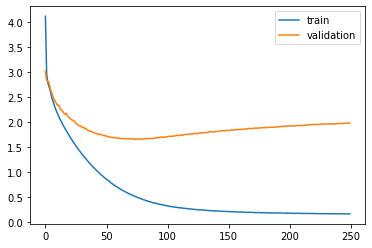

In [ ]:
num_epochs = 250 #250
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), epochs=num_epochs, batch_size=512, validation_split=0.2, callbacks=None, verbose=1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()
model.save('en-de-model.h5')

In [ ]:
num_epochs = 100 #250
model = make_model(eng_vocab_size, deu_vocab_size, eng_length, deu_length, 128)
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), epochs=num_epochs, batch_size=128, validation_split=0.2, callbacks=None, verbose=2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()
model.save('en-de-model.h5')

Epoch 1/100
300/300 - 19s - loss: 3.7547 - accuracy: 0.4980 - val_loss: 3.3085 - val_accuracy: 0.5309 - 19s/epoch - 62ms/step
Epoch 2/100
300/300 - 10s - loss: 3.2463 - accuracy: 0.5382 - val_loss: 3.0588 - val_accuracy: 0.5481 - 10s/epoch - 35ms/step
Epoch 3/100
300/300 - 11s - loss: 3.0280 - accuracy: 0.5633 - val_loss: 2.8952 - val_accuracy: 0.5754 - 11s/epoch - 38ms/step
Epoch 4/100
300/300 - 10s - loss: 2.9017 - accuracy: 0.5760 - val_loss: 2.8456 - val_accuracy: 0.5854 - 10s/epoch - 34ms/step
Epoch 5/100
300/300 - 10s - loss: 2.8137 - accuracy: 0.5864 - val_loss: 2.7509 - val_accuracy: 0.5953 - 10s/epoch - 34ms/step
Epoch 6/100
300/300 - 11s - loss: 2.7341 - accuracy: 0.5940 - val_loss: 2.6857 - val_accuracy: 0.6013 - 11s/epoch - 38ms/step
Epoch 7/100
300/300 - 10s - loss: 2.6657 - accuracy: 0.6009 - val_loss: 2.6429 - val_accuracy: 0.6047 - 10s/epoch - 34ms/step
Epoch 8/100
300/300 - 10s - loss: 2.6098 - accuracy: 0.6066 - val_loss: 2.5799 - val_accuracy: 0.6150 - 10s/epoch - 34

In [20]:
model = load_model('en-de-model.h5')

In [21]:
def get_word(n, tokenizer):
    if n == 0:
        return ""
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return ""

In [22]:
phrs_enc = encode_sequences(eng_tokenizer, eng_length, ["the weather is nice today", "my name is tom", "how old are you", "where is the nearest shop"])
print("phrs_enc:", phrs_enc.shape)

preds = np.argmax(model.predict(phrs_enc), axis=-1)
print("Preds:", preds.shape)
print(preds[0])
print(get_word(preds[0][0], deu_tokenizer), get_word(preds[0][1], deu_tokenizer), get_word(preds[0][2], deu_tokenizer), get_word(preds[0][3], deu_tokenizer))
print(preds[1])
print(get_word(preds[1][0], deu_tokenizer), get_word(preds[1][1], deu_tokenizer), get_word(preds[1][2], deu_tokenizer), get_word(preds[1][3], deu_tokenizer))
print(preds[2])
print(get_word(preds[2][0], deu_tokenizer), get_word(preds[2][1], deu_tokenizer), get_word(preds[2][2], deu_tokenizer), get_word(preds[2][3], deu_tokenizer))
print(preds[3])
print(get_word(preds[3][0], deu_tokenizer), get_word(preds[3][1], deu_tokenizer), get_word(preds[3][2], deu_tokenizer), get_word(preds[3][3], deu_tokenizer))
print()

phrs_enc: (4, 8)
1/1 [==============================] - 1s 1s/step
Preds: (4, 8)
[  42    3    3 2736    0    0    0    0]
der ist ist vorüber
[   2 1354    1  775    0    0    0    0]
ich heiße tom name
[ 37 166  19   4   0   0   0   0]
wie alt sind sie
[  77    3   20 2991    0    0    0    0]
wo ist die zoo



In [23]:
phrs_enc = encode_sequences(eng_tokenizer, eng_length, ["home", "building", "house", "formation"])
print("phrs_enc:", phrs_enc.shape)

preds = np.argmax(model.predict(phrs_enc), axis=-1)
print("Preds:", preds.shape)
print(preds[0])
print(get_word(preds[0][0], deu_tokenizer), get_word(preds[0][1], deu_tokenizer), get_word(preds[0][2], deu_tokenizer), get_word(preds[0][3], deu_tokenizer))
print(preds[1])
print(get_word(preds[1][0], deu_tokenizer), get_word(preds[1][1], deu_tokenizer), get_word(preds[1][2], deu_tokenizer), get_word(preds[1][3], deu_tokenizer))
print(preds[2])
print(get_word(preds[2][0], deu_tokenizer), get_word(preds[2][1], deu_tokenizer), get_word(preds[2][2], deu_tokenizer), get_word(preds[2][3], deu_tokenizer))
print(preds[3])
print(get_word(preds[3][0], deu_tokenizer), get_word(preds[3][1], deu_tokenizer), get_word(preds[3][2], deu_tokenizer), get_word(preds[3][3], deu_tokenizer))
print()

phrs_enc: (4, 8)
1/1 [==============================] - 0s 20ms/step
Preds: (4, 8)
[67 55 67  0  0  0  0  0]
hause geht hause 
[2800    0    0    0    0    0    0    0]
bienen   
[  1  34 238   0   0   0   0   0]
tom aus haus 
[2800    0    0    0    0    0    0    0]
bienen   

